<a href="https://colab.research.google.com/github/marinacer/IA048/blob/main/glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Aplicar scaling para todos exceto random forest e explicar o método minmaxscaler que é um scaler robusto a outliners
2.   algoritmos variados: svm é linear, knn não paramemtrico
random forest não linear, ensemble
3. oversampling para compensar o desbalanceamento das classes
4. matriz de confusão para os melhores hiperparamentos de cada método


In [235]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [156]:
# open the csv file to dataframe
df = pd.read_csv('glass.csv')
df.head()

# atributes to X and labels to y
X = df.drop('Type',axis = 1)
y = df.Type
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [157]:
# label encoding. necessário para corrigir um erro do dataset na nomenclatura das classes
label = preprocessing.LabelEncoder()
label.fit(y)
y_label = label.transform(y)

In [158]:
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size = 0.30, random_state = 0)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size = 0.30, stratify = y)

In [159]:
# robust bom para dados com outliers
from sklearn.preprocessing import RobustScaler,MinMaxScaler
scale = MinMaxScaler()

Xtrain_scaled = scale.fit_transform(Xtrain)
Xtest_scaled = scale.transform(Xtest)

In [160]:
# dataframe to np.array
Xtrain = Xtrain.values
Xtest = Xtest.values

**Oversampling**

In [161]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
Xtrain_over, ytrain_over = oversample.fit_resample(Xtrain, ytrain)

oversample_scaled = RandomOverSampler(sampling_strategy='minority')
Xtrain_over_scaled, ytrain_over_scaled = oversample_scaled.fit_resample(Xtrain_scaled, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [169]:
# cross validation, evaluation e desempenho do Random Forest
def fit_random_forest(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(var)

  for j in range(0,var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):
      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      clf = RandomForestClassifier(max_depth = j+1, n_estimators = 500)
      clf.fit(Xtrain_kfold, ytrain_kfold)
      ypred_kfold = clf.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
    acc_vec[j] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = acc_vec.argmax() + 1

  # método com o hiperparâmetro ideal
  clf = RandomForestClassifier(max_depth=best_var, n_estimators = 100)
  clf.fit(Xtrain_p, ytrain_p)
  y_predict = clf.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  return(best_var,f1_predict,acc_predict)

(12, 0.7596755368814193, 0.8)

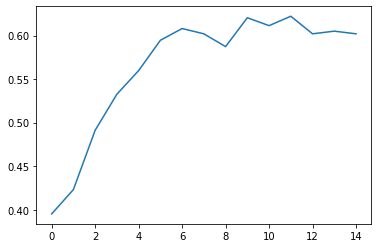

In [170]:
fit_random_forest(15,Xtrain,ytrain,Xtest,ytest)

(5, 0.6972109304426378, 0.7692307692307693)

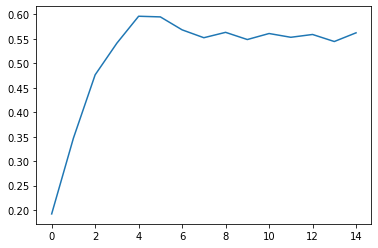

In [171]:
fit_random_forest(15,Xtrain_over,ytrain_over,Xtest,ytest)

(8, 0.7158165591818122, 0.7846153846153846)

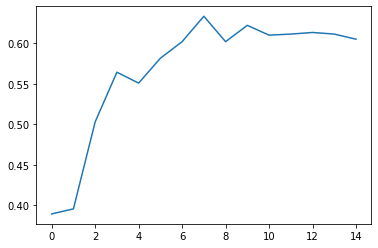

In [175]:
fit_random_forest(15,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

(5, 0.7133005633607946, 0.7692307692307693)

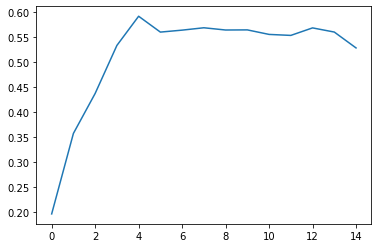

In [182]:
fit_random_forest(15,Xtrain_over_scaled,ytrain_over_scaled,Xtest_scaled,ytest)

In [184]:
def fit_knn(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(var)
  
  for j in range(0,var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):
      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      neigh = KNeighborsClassifier(n_neighbors = j+1)
      neigh.fit(Xtrain_kfold, ytrain_kfold)
      ypred_kfold = neigh.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
    acc_vec[j] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = acc_vec.argmax() + 1

  # método com o hiperparâmetro ideal
  neigh = KNeighborsClassifier(n_neighbors = best_var)
  neigh.fit(Xtrain_p, ytrain_p)
  y_predict = neigh.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  return(best_var,f1_predict,acc_predict)

(1, 0.684437321937322, 0.7384615384615385)

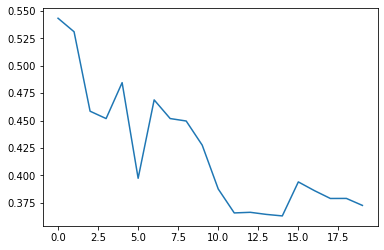

In [185]:
fit_knn(20,Xtrain,ytrain,Xtest,ytest)

(2, 0.594047619047619, 0.676923076923077)

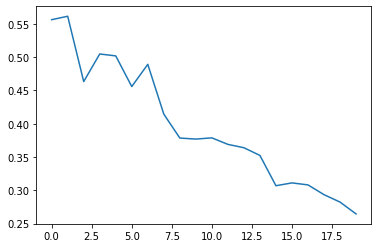

In [186]:
fit_knn(20,Xtrain_over,ytrain_over,Xtest,ytest)

(1, 0.5999741200828158, 0.6461538461538462)

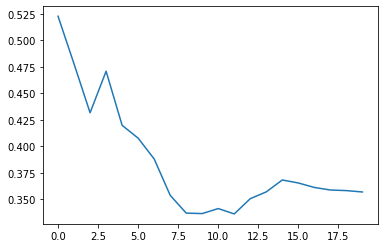

In [187]:
fit_knn(20,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

(1, 0.5999741200828158, 0.6461538461538462)

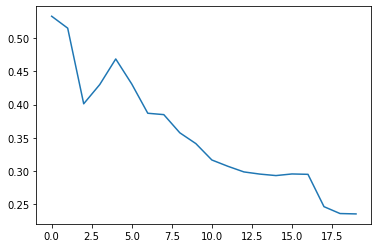

In [188]:
fit_knn(20,Xtrain_over_scaled,ytrain_over_scaled,Xtest_scaled,ytest)

In [238]:
def fit_svc(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(len(var))
  
  for i,j in enumerate(var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):

      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      

      reg = SVC(gamma='auto',kernel='linear',C=j)
      reg.fit(Xtrain_kfold,ytrain_kfold)
      ypred_kfold = reg.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
      
    acc_vec[i] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = var[acc_vec.argmax()]

  # método com o hiperparâmetro ideal
  reg = SVC(gamma='auto',kernel='linear',C=best_var)
  reg.fit(Xtrain_p,ytrain_p)
  y_predict = reg.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  return(best_var,f1_predict,acc_predict)

In [245]:
vec_reg = [1e-1,1e+0,1e+1,1e+2,1e+3,1e+4,1e+5,1e+6,1e+7]

(1000.0, 0.5387995811776299, 0.6153846153846154)

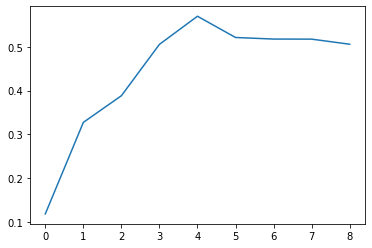

In [246]:
fit_svc(vec_reg,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

(100.0, 0.5602477477477478, 0.6153846153846154)

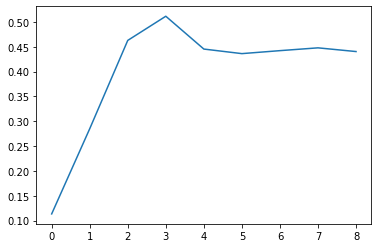

In [247]:
fit_svc(vec_reg,Xtrain_over_scaled,ytrain_over_scaled,Xtest_scaled,ytest)

**Regressão Logística**

In [230]:
def fit_reg(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(len(var))
  
  for i,j in enumerate(var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):

      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      reg = LogisticRegression(fit_intercept=True,multi_class='multinomial', C=j,max_iter=500)
      reg.fit(Xtrain_kfold,ytrain_kfold)
      ypred_kfold = reg.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
      
    acc_vec[i] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = var[acc_vec.argmax()]

  # método com o hiperparâmetro ideal
  reg = LogisticRegression(fit_intercept=True,multi_class='multinomial', C=best_var,max_iter=500)
  reg.fit(Xtrain_p,ytrain_p)
  y_predict = reg.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  return(best_var,f1_predict,acc_predict)

In [231]:
vec_reg = [1e+1,1e+2,1e+3,1e+4,1e+5,1e+6,1e+7]
acc_vec = np.zeros(len(vec_reg))
acc_vec

array([0., 0., 0., 0., 0., 0., 0.])

In [232]:
for i,j in enumerate(vec_reg):
  print(i,j)

0 10.0
1 100.0
2 1000.0
3 10000.0
4 100000.0
5 1000000.0
6 10000000.0


In [ ]:
fit_reg(vec_reg,Xtrain,ytrain,Xtest,ytest)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


(1000.0, 0.5977249874308698, 0.6307692307692307)

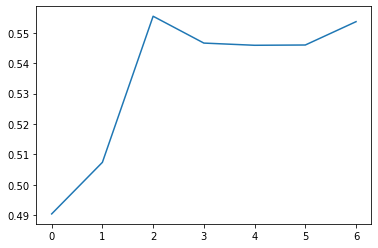

In [234]:
fit_reg(vec_reg,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

**Gráficos e Visualizações**

Text(0.5, 1.0, 'Accuracy Score: 0.8154')

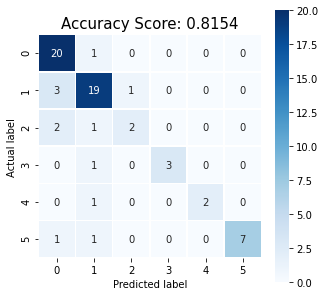

In [ ]:
# confusion matrix with sns
plt.figure(figsize=(5,5))
sns.heatmap(cmatrix_ran, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest,y_ran))
plt.title(all_sample_title, size = 15)

Quantidade de amostras total: [70 76 17 13  9 29]


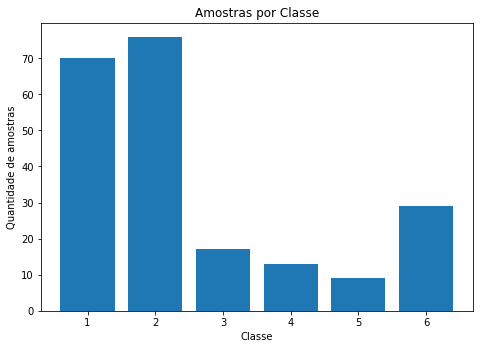

In [ ]:
# gráfico da quantidade de amostras por classe
unique, counts = np.unique(y, return_counts=True)
print("Quantidade de amostras total:",counts)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([1,2,3,4,5,6],[70,76,17,13,9,29])
plt.title("Amostras por Classe")
plt.xlabel("Classe")
plt.ylabel("Quantidade de amostras")
plt.show()

In [ ]:
# correlation matrix
corrMatrix = X.corr()
#fig, ax = plt.subplots(figsize=(20,10))
#sns.heatmap(corrMatrix, annot=True, ax=ax,cmap="YlGnBu", center = 0)
#plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


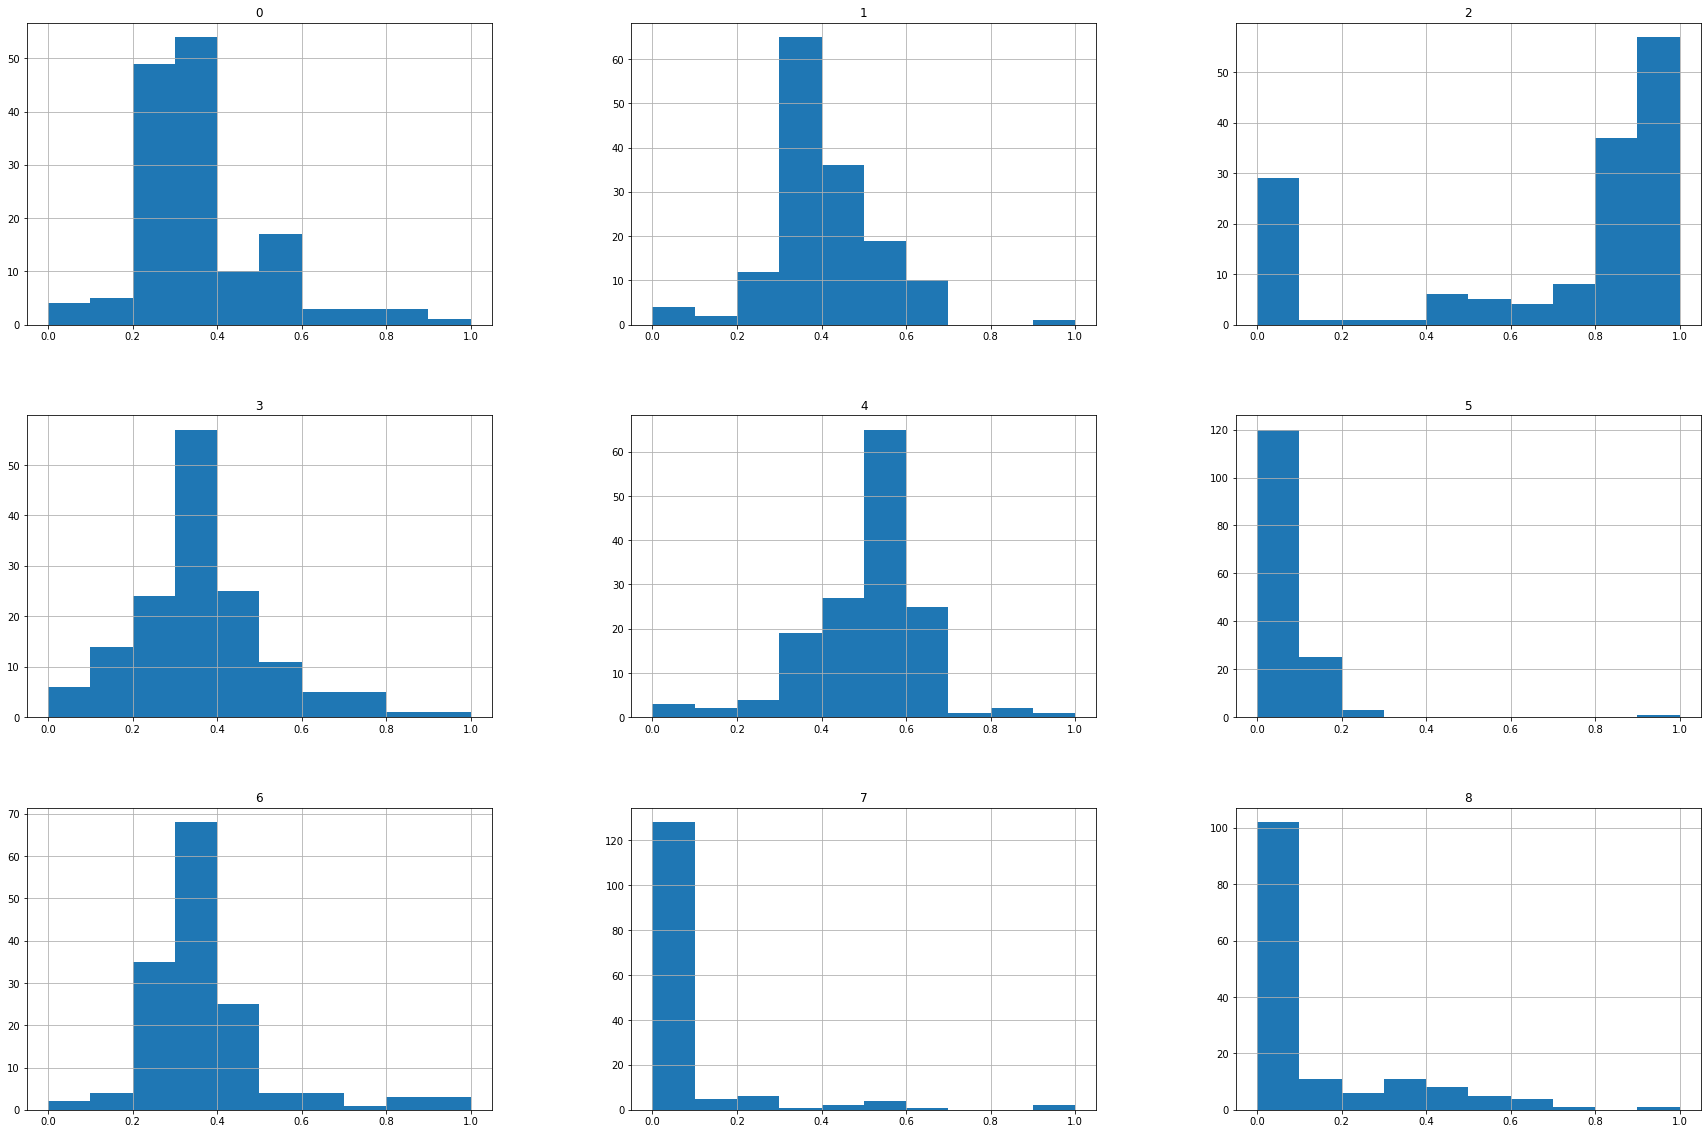

In [248]:
# histogram
Xtrainpd = pd.DataFrame(Xtrain_scaled)
fig, ax = plt.subplots(figsize=(30,20)) 
Xtrainpd.hist(ax = ax)
pass

**Rascunho**

Non oversampling
F1medida =  0.5273335411633284
Acurácia =  0.676923076923077 

Oversampling
F1medida =  0.7017371517371518
Acurácia =  0.7230769230769231


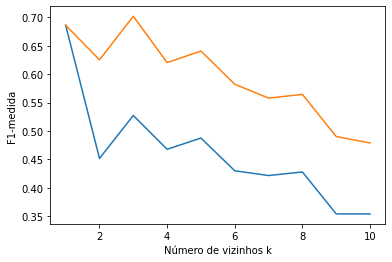

In [205]:
# KNN

F1medida_knn_1 = []
nknn = 11
for i in range(1,nknn):
    neigh_1 = KNeighborsClassifier(n_neighbors = i)
    neigh_1.fit(Xtrain, ytrain)
    y_knn_1 = neigh_1.predict(Xtest)

    F1medida_knn_1.append(f1_score(ytest, y_knn_1, average='macro'))
    #print('F1medida para k = ',i, ': ', F1medida_knn_2[i-1])
    #print('Matriz de confusão para k = ', i)
    #print(sk.confusion_matrix(ytest,y_knn_2))
    #print()
plt.plot(range(1,nknn),F1medida_knn_1)
plt.xlabel('Número de vizinhos k');
plt.ylabel('F1-medida');
pass

F1medida_knn_2 = []
nknn = 11
for i in range(1,nknn):
    neigh_2 = KNeighborsClassifier(n_neighbors = i)
    neigh_2.fit(Xtrain_over, ytrain_over)
    y_knn_2 = neigh_2.predict(Xtest)

    F1medida_knn_2.append(f1_score(ytest, y_knn_2, average='macro'))
    #print('F1medida para k = ',i, ': ', F1medida_knn_2[i-1])
    #print('Matriz de confusão para k = ', i)
    #print(sk.confusion_matrix(ytest,y_knn_2))
    #print()
plt.plot(range(1,nknn),F1medida_knn_2)
plt.xlabel('Número de vizinhos k');
plt.ylabel('F1-medida');
pass

neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(Xtrain, ytrain)
y_knn = neigh.predict(Xtest)
f1_knn = f1_score(ytest, y_knn, average='macro')
cmatrix_knn = sk.confusion_matrix(ytest,y_knn)

print('Non oversampling')
print('F1medida = ', f1_knn)
print('Acurácia = ',accuracy_score(ytest,y_knn),'\n')

neigh_over = KNeighborsClassifier(n_neighbors = 1)
neigh_over.fit(Xtrain_over, ytrain_over)
y_knn_over = neigh_over.predict(Xtest)
f1_knn_over = f1_score(ytest, y_knn_over, average='macro')
cmatrix_knn_over = sk.confusion_matrix(ytest,y_knn_over)

print('Oversampling')
print('F1medida = ', f1_knn_over)
print('Acurácia = ',accuracy_score(ytest,y_knn_over))

In [197]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(Xtrain, ytrain)
y_ran = clf.predict(Xtest)
f1_ran = f1_score(ytest, y_ran, average='macro')
cmatrix_ran = sk.confusion_matrix(ytest,y_ran)

print('Non oversampling')
print('F1medida = ', f1_ran)
print('Acurácia = ',accuracy_score(ytest,y_ran),'\n')

clf_over = RandomForestClassifier(max_depth=10, random_state=0)
clf_over.fit(Xtrain_over, ytrain_over)
y_ran_over = clf_over.predict(Xtest)
f1_ran_over = f1_score(ytest, y_ran_over, average='macro')
cmatrix_ran_over = sk.confusion_matrix(ytest,y_ran_over)

print('Oversampling')
print('F1medida = ', f1_ran_over)
print('Acurácia = ',accuracy_score(ytest,y_ran_over))

Non oversampling
F1medida =  0.7183080808080807
Acurácia =  0.7538461538461538 

Oversampling
F1medida =  0.7300911854103344
Acurácia =  0.7384615384615385


In [ ]:
#sns.FacetGrid(df,hue="Type",height=5).map(sns.distplot,"RI").add_legend();

F1medida para k =  1 :  0.7622270335022191
Matriz de confusão para k =  1
[[16  2  3  0  0  0]
 [ 5 16  2  0  0  0]
 [ 3  0  2  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  3  0]
 [ 1  0  0  1  0  7]]

F1medida para k =  2 :  0.7276234567901234
Matriz de confusão para k =  2
[[20  1  0  0  0  0]
 [ 7 15  1  0  0  0]
 [ 5  0  0  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  3  0]
 [ 1  1  0  0  0  7]]

F1medida para k =  3 :  0.7400729373875153
Matriz de confusão para k =  3
[[16  4  1  0  0  0]
 [ 5 17  0  0  1  0]
 [ 3  0  2  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  2  1]
 [ 0  2  0  0  0  7]]

F1medida para k =  4 :  0.6469580080094054
Matriz de confusão para k =  4
[[17  3  1  0  0  0]
 [ 6 15  1  0  1  0]
 [ 5  0  0  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  2  1]
 [ 0  2  0  0  0  7]]

F1medida para k =  5 :  0.5904463913224864
Matriz de confusão para k =  5
[[15  6  0  0  0  0]
 [ 5 16  1  0  1  0]
 [ 5  0  0  0  0  0]
 [ 0  0  0  4  0  0]
 [ 1  0  0  0  1  1]
 [ 0  2  0  0

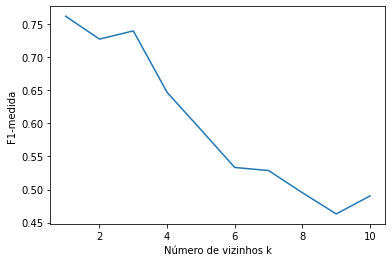

In [30]:
F1medida_knn_2 = []
nknn = 11
for i in range(1,nknn):
    neigh_2 = KNeighborsClassifier(n_neighbors = i)
    neigh_2.fit(Xtrain, ytrain)
    y_knn_2 = neigh_2.predict(Xtest)

    F1medida_knn_2.append(f1_score(ytest, y_knn_2, average='macro'))
    print('F1medida para k = ',i, ': ', F1medida_knn_2[i-1])
    print('Matriz de confusão para k = ', i)
    print(sk.confusion_matrix(ytest,y_knn_2))
    print()
plt.plot(range(1,nknn),F1medida_knn_2)
plt.xlabel('Número de vizinhos k');
plt.ylabel('F1-medida');
pass